<a href="https://colab.research.google.com/github/CarlosSMWolff/ParamEst-NN/blob/main/1-Trajectories_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generation of data using Monte Carlo method of quantum trajectories

## Goal

In this notebook, we populate the folder `[datapath]\training-trajectories` and  `[datapath]\validation-trajectories` with data of photon-counting quantum trajectories simulated with Qutip.
- Training trajectrories are used to populate the folder `[datapath]\training-trajectories` and are used to train models based in neural networks for the problem of quantum parameter estimation.
- Validation trajectories populate the folder `[datapath]\trajectories\training-trajectories` and are used to benchmark the trained models against other approaches based on Bayesian inference.

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
from tqdm import tqdm

## Setup and Requirements

### Colab setup

If this notebook is run online in Google Colab, we:
- Download the repository from GitHub.
- Install the custom pacakge

In [3]:
# Find out if this notebook is running in Google Colab
isColab= 'google.colab' in str(get_ipython())

# Download repository if we are in Colab and install "paramest_nn" package
if isColab:
  print('We are running in Colab. Cloning repository.')
  # Download the repository (necessary to access functions in /src folder)
  ! git clone https://github.com/CarlosSMWolff/ParamEst-NN

  print('Repository downloaded.')
  ! mv ParamEst-NN/* . && rm -r ParamEst-NN

  print('Installing paramest_nn package')
  ! pip install -q -e .

We are running in Colab. Cloning repository.
Cloning into 'ParamEst-NN'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 201 (delta 106), reused 138 (delta 57), pack-reused 0
Receiving objects: 100% (201/201), 2.21 MiB | 21.77 MiB/s, done.
Resolving deltas: 100% (106/106), done.
Repository downloaded.
Installing paramest_nn package
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 60.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wh

### Import custom packages + Qutip

In [4]:
from paramest_nn.quantum_tools import *
from qutip import *

### Data path

In [5]:
# specify the data path
datapath = '../data/'

# if running in Colab, remove the "../"
if isColab:
    datapath = datapath.split("../")[1]

Create data folder in the datapath if not already present

In [6]:
create_directory(datapath)

Directory data/ not found: creating...


### Number of CPUs (Qutip)

In order to benefit from parallelization, we set up the number of available CPUs for Qutip to use

In [7]:
import multiprocessing
num_cpus = multiprocessing.cpu_count()

# We set the maximum number of cpus available to Qutip as the total number-1
max_cpus=num_cpus-1
qutip.settings.num_cpus = max_cpus
print(f"Number of CPUs available for Qutip: {max_cpus}")

Number of CPUs available for Qutip: 1


## Generation of training data for 1D case (estimation of $\Delta$)

Set up parameter to create the model of the system in Qutip

In [8]:
N=2
omega=1
gamma=1

- I will generate randomly the parameters, and only one trajectory per parameter, in order to avoid any weird information leaking.
- Number of clicks per trajectory: `njumpsMC`
- Total number of trajectories generated for training: `ndeltas`

In [ ]:
# Number of clicks per trajectory
njumpsMC=48

# Number of total trajectories to generate
ndeltas = 4000000

# Generation of a list of random values of Delta
deltamin = 0
deltamax = 5.
delta_rand_list = deltamin + (deltamax-deltamin)*rand(ndeltas)
omega_list = omega*np.ones(ndeltas)

param_rand_list = list(zip(delta_rand_list,omega_list))

In [ ]:
trajectories = np.asarray(parallel_map(generate_clicks_TLS, param_rand_list, task_kwargs=dict(njumpsMC = njumpsMC, gamma=gamma), progress_bar = True))

10.0%. Run time:   2.95s. Est. time left: 00:00:00:26
20.0%. Run time:   4.50s. Est. time left: 00:00:00:17
30.0%. Run time:   5.74s. Est. time left: 00:00:00:13
40.0%. Run time:   8.95s. Est. time left: 00:00:00:13
50.0%. Run time:  11.85s. Est. time left: 00:00:00:11
60.0%. Run time:  16.08s. Est. time left: 00:00:00:10
70.0%. Run time:  18.82s. Est. time left: 00:00:00:08
80.0%. Run time:  19.92s. Est. time left: 00:00:00:04
90.0%. Run time:  20.89s. Est. time left: 00:00:00:02
100.0%. Run time:  21.26s. Est. time left: 00:00:00:00
Total run time:  21.27s


The trajectories created have the form of time delays

In [ ]:
trajectories.shape

(40, 48)

In [ ]:
trajectories[0]

array([ 4.43402513,  2.3886161 ,  4.8817266 ,  0.62577689, 37.68466402,
       10.84851649,  0.63805102,  2.58503013,  5.38243978,  6.32973579,
       18.25509825, 16.83327603, 40.60946179, 15.65403671, 10.2685811 ,
       19.52126509,  0.80203617,  2.49113429, 40.8429149 ,  3.93519161,
       27.72043287, 12.32049623,  6.56572356,  9.48338546,  0.82344364,
        0.8083468 , 20.93628793, 48.41338955, 11.07159081,  6.26323702,
        4.53217603, 10.66269477, 41.18669043,  0.30280435,  7.61444605,
       73.31877339,  9.75086728, 39.6282455 , 25.9679248 ,  8.50707961,
        2.05307298, 24.72837637, 28.57366745, 10.25831667, 18.74943281,
       11.6136214 ,  9.76640426,  0.85582315])

Save the trajetories into the `[datapath]/training-trajectories/1D-delta` folder

In [ ]:
filedir = datapath+'training-trajectories/1D-delta/'
create_directory(filedir)

filename = filedir+'taus-Delta-1D'
filenameDeltas = filedir+'delta_rand_list-Delta-1D'

np.save(filename,trajectories)
np.save(filenameDeltas,delta_rand_list)

Directory data/training-trajectories/1D-delta/ not found: creating...


## Generation of training data for 2D case (estimation of $\Delta$ and $\Omega$)

We sample the parameters randomly, and create only one trajectory per parameter

In [ ]:
nparams = 4000000

deltamin = 0.
deltamax = 3.

omegamin =0.25
omegamax = 5.

omega_rand_list = omegamin + (omegamax-omegamin)*rand(nparams)
delta_rand_list = deltamin + (deltamax-deltamin)*rand(nparams)

In [ ]:
param_rand_list = list(zip(delta_rand_list,omega_rand_list))
param_rand_array = np.array(param_rand_list)

Visualization of the distribution of parameters sampled for training

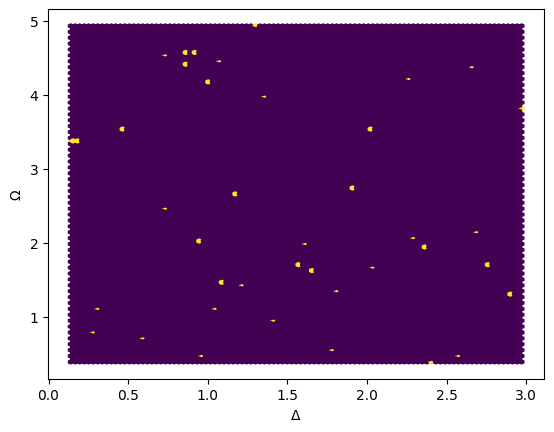

In [ ]:
plt.hexbin(delta_rand_list,omega_rand_list)
plt.xlabel('$\Delta$'); plt.ylabel('$\Omega$')
plt.show()

In [ ]:
trajectories = np.array(parallel_map(generate_clicks_TLS, param_rand_list,num_processes=19, progress_bar = True))

10.0%. Run time:   1.20s. Est. time left: 00:00:00:10
20.0%. Run time:   3.36s. Est. time left: 00:00:00:13
30.0%. Run time:   4.63s. Est. time left: 00:00:00:10
40.0%. Run time:   5.79s. Est. time left: 00:00:00:08
50.0%. Run time:   6.28s. Est. time left: 00:00:00:06
60.0%. Run time:   6.69s. Est. time left: 00:00:00:04
70.0%. Run time:   8.00s. Est. time left: 00:00:00:03
80.0%. Run time:   8.57s. Est. time left: 00:00:00:02
90.0%. Run time:   9.18s. Est. time left: 00:00:00:01
100.0%. Run time:   9.77s. Est. time left: 00:00:00:00
Total run time:   9.78s


Save the trajetories into the `data/training/2D-delta-omega` folder

In [ ]:
# Save files to disk

filedir = datapath+'training-trajectories/2D-delta-omega/'
create_directory(filedir)

filename = filedir+'taus2D'
filenameParams = filedir+'param_rand_list-2D'

np.save(filename,trajectories)
np.save(filenameParams,param_rand_array)

Directory data/training-trajectories/2D-delta-omega/ not found: creating...


## Generation of validation clicks for 1D case

Setup Qutip operators

In [ ]:
N=2
a=destroy(N)
psi0=basis(N,0)
c_ops=[]
gamma=1
c_ops.append(np.sqrt(gamma)*a)


Notice that for the validation, we will generate many trajectories for the same value of the parameter, unlike in the training data.

- Number of points in the grid of $\Delta$ values considered for the validation: `ndelta`

- Number of trajectories for each value of the grid of parameters: `ntraj`



In [ ]:
ndelta = 40
ntraj = 10000

omega=1
deltaMax = 2.1
t0=0

njumpsMC=48 # to keep
njumpsSim = 60 # to actually run, we choose much larger than the number of clicks we plan to keep

deltagrid = np.linspace(0.,deltaMax,ndelta)
jumpArray = np.zeros((ndelta,ntraj,njumpsMC))

In [ ]:
for idx_delta in tqdm(range(ndelta)):
    delta = deltagrid[idx_delta]
    # Estimate the final time to have, on average, njumpsSim jumps
    tf=njumpsSim*(4*delta**2+8*omega**2+gamma**2)/(4*gamma*omega**2)
    H=delta*a.dag()*a+omega*a+omega*a.dag()
    tlist=[t0,tf] #

    ntrajRemaining = ntraj
    jumpList = []
    trajs_to_complete = [[] for i in range(ntraj)]
    trajs_completed   = []

    while ntrajRemaining > 0:
        mc=mcsolve(H,psi0,tlist,c_ops,[],ntrajRemaining,progress_bar=False)
        time_array = mc.col_times

        # Append the results into the trajectories in trajs_to_complete
        # WARNING: Appending different trajectories into a single one is only valid for the TLS, which gets reseted after each jump
        for idx, times in enumerate(time_array):
            trajs_to_complete[idx]+= list(to_time_delay(times))

        sizes = np.array([len(traj) for traj in trajs_to_complete])
        good_indexes = np.arange(ntrajRemaining)[sizes>=njumpsMC]
        bad_indexes = np.arange(ntrajRemaining)[sizes<njumpsMC]
        n_good_traj = len(good_indexes)
        ntrajRemaining = ntrajRemaining - n_good_traj

        # Trajectories with njumpsMC jumps are moved into trajs_completed
        for idx in good_indexes:
            trajs_completed += [trajs_to_complete[idx][:njumpsMC]]

        # Remove completed trajectory from trajs_to_complete
        trajs_to_complete = [trajs_to_complete[idx] for idx in bad_indexes]


    jumpArray[idx_delta,:,:] = np.asarray(trajs_completed)

100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


In [ ]:
filedir = datapath+'validation-trajectories/1D-delta/'
create_directory(filedir)

filenameJumps = filedir+f'validation-trajectories-1D-delta-nsets-{ntraj}'
filenameParams = filedir+f'validation-deltas-1D-delta-nsets-{ntraj}'

np.save(filenameJumps,jumpArray)
np.save(filenameParams,deltagrid)

Directory data/validation-trajectories/1D-delta/ not found: creating...


## Generation of validation clicks for 2D case

Setup Qutip operators

In [ ]:
N=2
a=destroy(N)
psi0=basis(N,0)
c_ops=[]
gamma=1
c_ops.append(np.sqrt(gamma)*a)


Notice that for the validation, we will generate many trajectories for the same value of the parameter pairs, unlike in the training data.

- Number of points in the grid of $\Delta$ values considered for the validation: `ndelta`
- Number of points in the grid of $\Omega$ values considered for the validation: `nomega`
- Number of trajectories for each value of the square grid of parameters: `ntraj`



In [ ]:
ndelta = 40
nomega = 40

ntraj = 10000
deltamin = 0.
deltamax = 2.1

omegamin =0.25
omegamax = 2.1

njumpsMC=48 # to keep
njumpsSim = 60 # to actually run, we choose much larger than the number of clicks we plan to keep


deltagrid = np.linspace(deltamin,deltamax,ndelta)
omegagrid = np.linspace(omegamin,omegamax,nomega)

def gen_param_list(array1,array2):
    return np.array(np.meshgrid(array1,array2)).T.reshape(-1,2)

param_grid = gen_param_list(deltagrid,omegagrid)
nparams = ndelta*nomega

jumpArray = np.zeros((nparams,ntraj,njumpsMC))

In [ ]:
for idx_param in tqdm(range(nparams)):
    delta = param_grid[idx_param][0]
    omega = param_grid[idx_param][1]
    tf=njumpsSim*(4*delta**2+8*omega**2+gamma**2)/(4*gamma*omega**2)
    H=delta*a.dag()*a+omega*a+omega*a.dag()
    tlist=[0.,tf] #

    ntrajRemaining = ntraj
    jumpList = []
    trajs_to_complete = [[] for i in range(ntraj)]
    trajs_completed   = []

    while ntrajRemaining > 0:
        mc=mcsolve(H,psi0,tlist,c_ops,[],ntrajRemaining,progress_bar=False)
        time_array = mc.col_times

        # Append the results into the trajectories in trajs_to_complete
        # WARNING: Appending different trajectories into a single one is only valid for the TLS, which gets reseted after each jump
        for idx, times in enumerate(time_array):
            trajs_to_complete[idx]+= list(to_time_delay(times))

        sizes = np.array([len(traj) for traj in trajs_to_complete])
        good_indexes = np.arange(ntrajRemaining)[sizes>=njumpsMC]
        bad_indexes = np.arange(ntrajRemaining)[sizes<njumpsMC]
        n_good_traj = len(good_indexes)
        ntrajRemaining = ntrajRemaining - n_good_traj

        # Trajectories with njumpsMC jumps are moved into trajs_completed
        for idx in good_indexes:
            trajs_completed += [trajs_to_complete[idx][:njumpsMC]]

        # Remove completed trajectory from trajs_to_complete
        trajs_to_complete = [trajs_to_complete[idx] for idx in bad_indexes]


    jumpArray[idx_param,:,:] = np.asarray(trajs_completed)

100%|██████████| 1600/1600 [02:34<00:00, 10.37it/s]


In [ ]:
filedir = datapath+'validation-trajectories/2D-delta-omega/'
create_directory(filedir)

filenameJumps = filedir+f'validation-trajectories-2D-delta-omega-nsets-{ntraj}'
filenameParams = filedir+f'validation-deltas-2D-delta-omega-nsets-{ntraj}'

np.save(filenameJumps,jumpArray)
np.save(filenameParams,param_grid)

Directory data/validation-trajectories/2D-delta-omega/ not found: creating...


Given the high volume of trajectories, subsequent analysis can benefit from a splitted dataset.

Here, we split the datasets in 10 batches

In [ ]:
nbatches = 10
ntraj_per_batch = int(ntraj/nbatches)

In [ ]:
jumpArray2 = np.reshape(jumpArray,(1600,nbatches,ntraj_per_batch,48))

In [ ]:
for i in range(nbatches):
    np.save(filedir+f"validation-trajectories-10ktrajs-batch-{i}.npy",jumpArray2[:,i,:,:])